# This notebook demonstrates how to use pyroot's bindings to c++, to enable reading root files into python, though embedded c++ code in the jupyter notebook


In [1]:
import numpy as np
import ROOT

Welcome to JupyROOT 6.16/00


## First, some simple examples showing how to bind to cpp and pass information to and from python ##

In [2]:
%%cpp
//"cpp is now enabled in this block of code"
#include <iostream>
float a = 6;
cout <<"a = " <<a<<endl;

a = 6


In [3]:
%%cpp -d
//"the following function is interpreted as cpp"
float mag() {
    return 9.0;
}

In [4]:
a = ROOT.mag()
a

9.0

### You can pass an array in the following way

In [5]:
%%cpp -d
void simple_array(double out[]) {
    //"note that the length of the loop is hard coded, to emulate an unknown number of events"
    for (int i = 0; i < 4; i++) {
        out[i] = sqrt(i);
    }
}

Needing to know the size of the array before the function can problematic. One soultion is to guess high on the size, and to truncate the array after filling

In [6]:
a = np.empty(6)
a[:] = np.nan
print("start with:", a)
ROOT.simple_array(a)
a = a[~np.isnan(a)]
print("end with:", a)

start with: [nan nan nan nan nan nan]
end with: [0.         1.         1.41421356 1.73205081]


### We can pass two independent arrays and their lengths

In [7]:
%%cpp -d
void two_arrays(double out1[], double out2[], double* shape) {
    int N = 4; //"a 'hidden' size"
    int M = 5; //"a 'hidden' size"
    shape[0] = N;
    shape[1] = M;
    for (int i = 0; i < N; i++) {
        out1[i] = sqrt(i);
    }
    for (int j = 0; j < M; j++) {
         out2[j] = -j*2.0;
    }   
}

In [8]:
n = 7
m = 7
a = np.empty(n)
a[:] = np.nan
b = np.empty(m)
b[:] = np.nan
shape = np.zeros(2)

ROOT.two_arrays(a,b,shape)

a = a[0:int(shape[0])]
b = b[0:int(shape[1])]
print("a =", a)
print("b =", b)
print("the size of a and b is",shape)


a = [0.         1.         1.41421356 1.73205081]
b = [ 0. -2. -4. -6. -8.]
the size of a and b is [4. 5.]


### We can pass multi-dim arrays by mapping them onto 1-dim arrays ###
Below we fold a dim-2 IxJ array into a dim-1 I*J array by letting
```python
dim_2[i][j] = dim_1[i*J + j]
```

In [9]:
%%cpp -d
void nested_arrays(double out1[], double out2[], double shape[]) {
    int I = 4;
    int J = 5;
    shape[0] = I;
    shape[1] = J;
    for (int i = 0; i < I; i++) {
        out1[i] = sqrt(i);
        for (int j = 0; j < J; j++) {
            out2[i*J + j] = j;          
        }
    }   
}

In [10]:
I = 10
J = 10
a = np.zeros(I)
a[:] = np.nan
b = np.zeros((I + 1)*J)
b[:] = np.nan
shape = np.zeros(2)
ROOT.nested_arrays(a,b,shape)
#can throw in a saftey switch to ensure the array sizes were not under estimated
if ((I<shape[0]) or (J<shape[1])):
    raise TypeError("The arrays are larger than you guessed")
else:
    I=int(shape[0])
    J=int(shape[1])

We can unfold the 1d array into a 2d IxJ array using reshape. Note that each row in the 2d array corresponds to an emulated "event"

In [11]:
a = a[~np.isnan(a)]
b = b[~np.isnan(b)]
b_2d = np.reshape(b, [I,J])
print("shape=" + str(shape) + "\n")
print("a=" + str(a) + "\n")
print("b = " + str(b) + "\n")
print("b, unfolded back to a 2d array, is b_2d = " + str(b_2d) + "\n")

shape=[4. 5.]

a=[0.         1.         1.41421356 1.73205081]

b = [0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4.]

b, unfolded back to a 2d array, is b_2d = [[0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]]



# Let's get some info from a gm2 root file #


### We can get the number of entries from a root file

In [12]:
%%cpp -d
#include "RootTreeStructs.h"
using namespace std;
int Entries(){
    int run = 3956;
//#    int probe = 0;
    TFile* filein = new TFile(Form("~/Desktop/FieldPlainRootOutput_0%d_tier1.root",run),"read");
    TDirectory * dTrolley = (TDirectory*)filein->Get("TreeGenTrolley");
    TTree* trolley = (TTree*)dTrolley->Get("trolley");
    int N = trolley->GetEntries();
    filein->Close();
    return N;
}

In [13]:
n_entries = ROOT.Entries()
n_entries

8781

### We can get further info from the gm2 field root file

In [14]:
%%cpp -d
#include "RootTreeStructs.h"
using namespace std;
void FreqPhi(double* f, double* p, int run, int probe){
//  int run = 3956;
//  int probe = 0;
    TFile* filein = new TFile(Form("~/Desktop/FieldPlainRootOutput_0%d_tier1.root",run),"read");
    TDirectory * dTrolley = (TDirectory*)filein->Get("TreeGenTrolley");
    TTree* trolley = (TTree*)dTrolley->Get("trolley");
    gm2field::trolleyTimeStamp_t trolleyTimeStamp;
    gm2field::trolleyProbeFrequency_t trolleyProbeFrequency;
    gm2field::trolleyFieldMultipole_t trolleyFieldMultipole;
    gm2field::trolleyPosition_t trolleyPosition;
    trolley->SetBranchAddress("TimeStamp",&trolleyTimeStamp.GpsCycleStart);
    trolley->SetBranchAddress("ProbeFrequency",&trolleyProbeFrequency.Frequency);
    trolley->SetBranchAddress("FieldMultipole",&trolleyFieldMultipole.Multipole);
    trolley->SetBranchAddress("Position",&trolleyPosition.Phi);
///////////////////////////////////////////////////////////////////////////////////
    int nAllReadings = trolley->GetEntries();
    for(int i=0;i<nAllReadings;i++){ //loop through trolley events
        trolley->GetEntry(i);
        f[i] = trolleyProbeFrequency.Frequency[probe][0]; 
        p[i] = trolleyPosition.Phi[probe][2];
    }
    filein->Close();
    return;
}

In [15]:
n_entries = ROOT.Entries()
freq = np.empty(n_entries)
pos = np.empty(n_entries)
run = 3956
probe = 0
ROOT.FreqPhi(freq,pos,run,probe)

In [16]:
print(freq)
print(pos)

[-1.00000000e+00 -1.00000000e+00  1.48141515e+04 ...  5.28473212e+04
  5.28459467e+04  5.28466916e+04]
[262.19376043 262.19381813 262.19376777 ... 261.72356562 261.72356562
 261.72356562]


In [17]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.plot(pos, freq, 'o', color='black');

### Below is a simple demonstration of how you can pack the arrays of interest into a pandas df, and save, as a pickel file for later use ###

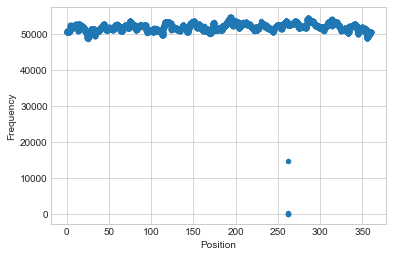

In [18]:
import pandas as pd
df = pd.DataFrame({'Frequency':freq, 'Position':pos})
df.plot('Position', 'Frequency', kind='scatter')


df.to_pickle("./freq_pos.pkl")

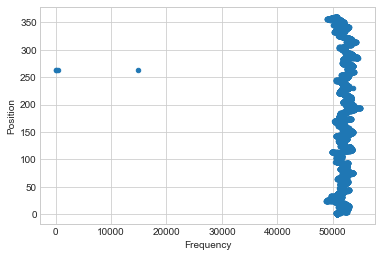

In [19]:
unpickled_df = pd.read_pickle("./freq_pos.pkl")
unpickled_df.plot('Frequency', 'Position', kind='scatter')

### Similarly, we can store a dict of pandas dataframes 

In [20]:
#create a dict to store the various probes' dataframes
all_data_frames = {}
n_entries = ROOT.Entries()
run = 3956
#get the arrays into dataframes into a dictionary, for a few probes, with the following loop
for probe in range(3):
    freq = np.empty(n_entries)
    pos = np.empty(n_entries)
    ROOT.FreqPhi(freq,pos,run,probe)
    df = pd.DataFrame({'Frequency':freq, 'Position':pos})
    all_data_frames[probe] = df

And we can save/load dict of dataframes with pickel

In [21]:
import pickle
with open("./freq_pos_dict.pkl", "wb") as f:
    pickle.dump(all_data_frames, f)

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


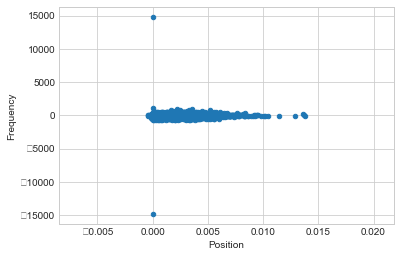

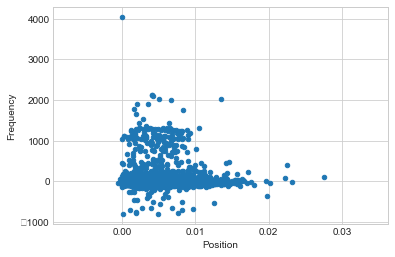

In [22]:
with open("freq_pos_dict.pkl", "rb") as f:
    loaded_data_frames = pickle.load(f)

#show that the loaded dict is storing information for distinct probes 
subtraction = loaded_data_frames[0] - loaded_data_frames[1]
subtraction.plot('Position', 'Frequency', kind='scatter')
subtraction = loaded_data_frames[0] - loaded_data_frames[2]
subtraction.plot('Position', 'Frequency', kind='scatter')

# Demonstrate how to pull FID length

In [23]:
%%cpp -d
#include "RootTreeStructs.h"
using namespace std;
void FidLength(double* f, double* p, double* fid_len, int run, int probe){
//  int run = 3956;
//  int probe = 0;
    TFile* filein = new TFile(Form("~/Desktop/FieldPlainRootOutput_0%d_tier1.root",run),"read");
    TDirectory * dTrolley = (TDirectory*)filein->Get("TreeGenTrolley");
    TTree* trolley = (TTree*)dTrolley->Get("trolley");
    gm2field::trolleyTimeStamp_t trolleyTimeStamp;
    gm2field::trolleyProbeFrequency_t trolleyProbeFrequency;
    gm2field::trolleyFieldMultipole_t trolleyFieldMultipole;
    gm2field::trolleyPosition_t trolleyPosition;
    trolley->SetBranchAddress("TimeStamp",&trolleyTimeStamp.GpsCycleStart);
    trolley->SetBranchAddress("ProbeFrequency",&trolleyProbeFrequency.Frequency);
    trolley->SetBranchAddress("FieldMultipole",&trolleyFieldMultipole.Multipole);
    trolley->SetBranchAddress("Position",&trolleyPosition.Phi);
    
    //#for FID length
    gm2field::trolleyProbeSignal_t trolleyProbeSignal;
    //#need to set the first one in the struct, which happens to be amplitude
    trolley->SetBranchAddress("ProbeSignal",&trolleyProbeSignal.Amplitude);
    
///////////////////////////////////////////////////////////////////////////////////
    int nAllReadings = trolley->GetEntries();
    for(int i=0;i<nAllReadings;i++){ //loop through trolley events
        trolley->GetEntry(i);
        f[i] = trolleyProbeFrequency.Frequency[probe][0]; 
        p[i] = trolleyPosition.Phi[probe][2];
        fid_len[i] = trolleyProbeSignal.FidLength[probe];
    }
    filein->Close();
    return;
}



In [24]:
n_entries = ROOT.Entries()
freq = np.empty(n_entries)
pos = np.empty(n_entries)
fid_len = np.empty(n_entries)
run = 3956
probe = 0
ROOT.FidLength(freq,pos,fid_len,run,probe)

In [25]:
df = pd.DataFrame({'Frequency':freq, 'Position':pos, "FID_len":fid_len})
print(df.head())

      Frequency    Position   FID_len
0     -1.000000  262.193760  0.000018
1     -1.000000  262.193818  0.000020
2  14814.151542  262.193768  0.000042
3    462.712654  262.193775  0.000057
4  52729.143614  262.193738  0.007718


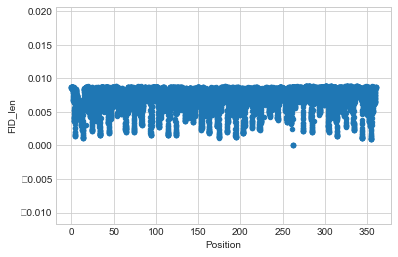

In [26]:
df.plot('Position', 'FID_len', kind='scatter')

# Show how to get the raw FIDs

In [27]:
%%cpp -d
#include "RootTreeStructs.h"
using namespace std;
void RawFid(double* raw_fid,  int run, int reading, int probe){
//  int run = 3956;
//  int probe = 0;
    TFile* filein = new TFile(Form("~/Desktop/FieldPlainRootOutput_0%d_tier1.root",run),"read");
    TDirectory * dMyTrolley = (TDirectory*)filein->Get("TrolleyWfExtraction");
    TTree* myTrolley = (TTree*)dMyTrolley->Get("trolleyWf");
    gm2field::trolleyFid_t trolleyFid;
    myTrolley->SetBranchAddress("trolleyFid", &trolleyFid.RawFid);
///////////////////////////////////////////////////////////////////////////////////
    int fidLength = 16000;
    int dataStartingPoint = probe*fidLength;    
    myTrolley->GetEntry(reading);                                
    for (int i=0; i<fidLength; i++) {
        raw_fid[i] = trolleyFid.RawFid[i];
    }
    filein->Close();
    return;
}

In [28]:
raw_fid = np.empty(16000)
reading = 4
probe = 0
run = 3956
ROOT.RawFid(raw_fid,run,reading,probe)

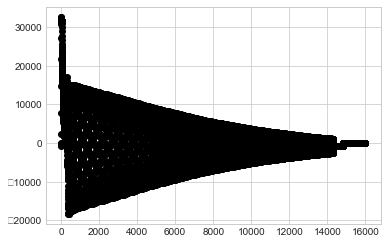

In [29]:
plt.plot(raw_fid, 'o', color='black');

# Select specific raw FIDs based on their length

## First, medium-length FIDS

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122f9b2e8>]],
      dtype=object)

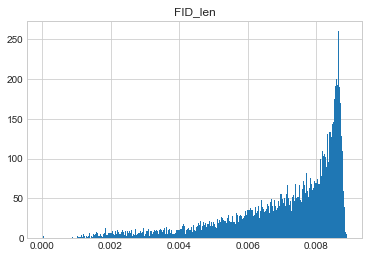

In [30]:
df.hist(column='FID_len',bins=300)

In [31]:
print(df.head(9))

      Frequency    Position   FID_len
0     -1.000000  262.193760  0.000018
1     -1.000000  262.193818  0.000020
2  14814.151542  262.193768  0.000042
3    462.712654  262.193775  0.000057
4  52729.143614  262.193738  0.007718
5  52728.010318  262.193753  0.007642
6  52729.616173  262.193716  0.007604
7  52729.007579  262.193661  0.007642
8  52729.169397  262.193804  0.007623


[441, 1004, 1647, 2475, 2504, 3531, 3552, 4327, 4934, 4936, 4945, 4983, 5974, 7056, 7803]


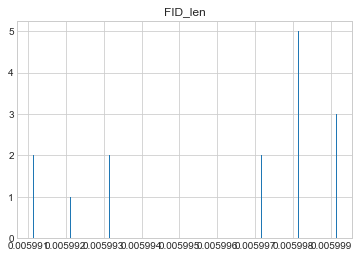

In [32]:
df_med_fids = df[ (fid_len > 0.00599) & (fid_len < 0.006) ]
df_med_fids.hist(column='FID_len',bins=300)
med_event_list = df_med_fids.index.tolist()
print(med_event_list)

In [33]:
# df_med_fids['RawFid'] = ""
df_med_fids.loc[:,"RawFid"].astype(object,copy=False)
# print(df_med_fids)

KeyError: 'RawFid'

In [ ]:
probe = 0
run = 3956
for reading in med_event_list:
    raw_fid = np.empty(16000)
    ROOT.RawFid(raw_fid,run,reading,probe)
    df_med_fids.at[reading, 'RawFid'] = raw_fid

In [ ]:
df_med_fids

## Second, medium-length FIDS

In [ ]:
df_long_fids = df[ (fid_len > 0.00879) & (fid_len < 0.0088) ]
df_long_fids.hist(column='FID_len',bins=300)
long_event_list = df_long_fids.index.tolist()
print(long_event_list)

In [ ]:
df_long_fids['RawFid'] = ""
df_long_fids['RawFid'].astype(object,copy=False)
print(df_long_fids)

In [ ]:
probe = 0
run = 3956
for reading in long_event_list:
    raw_fid = np.empty(16000)
    ROOT.RawFid(raw_fid,run,reading,probe)
    df_long_fids.at[reading, 'RawFid'] = raw_fid
print(df_long_fids)

## short FIDs, and very short FIDs

In [ ]:
df_short_fids = df[ (fid_len > 0.0039) & (fid_len < 0.004) ]
df_short_fids.hist(column='FID_len',bins=300)
short_event_list = df_short_fids.index.tolist()
print(short_event_list)
df_short_fids['RawFid'] = ""
df_short_fids['RawFid'].astype(object,copy=False)
print(df_short_fids)
probe = 0
run = 3956
for reading in short_event_list:
    raw_fid = np.empty(16000)
    ROOT.RawFid(raw_fid,run,reading,probe)
    df_short_fids.at[reading, 'RawFid'] = raw_fid
print(df_short_fids)

In [ ]:
df_vshort_fids = df[ (fid_len > 0.001) & (fid_len < 0.002) ]
df_vshort_fids.hist(column='FID_len',bins=300)
vshort_event_list = df_vshort_fids.index.tolist()
# print(vshort_event_list)
df_vshort_fids['RawFid'] = ""
df_vshort_fids['RawFid'].astype(object,copy=False)
# print(df_vshort_fids)
probe = 0
run = 3956
for reading in vshort_event_list:
    raw_fid = np.empty(16000)
    ROOT.RawFid(raw_fid,run,reading,probe)
    df_vshort_fids.at[reading, 'RawFid'] = raw_fid
# print(df_vshort_fids)

## Compare random FIDs from the four groups

In [ ]:
plt.plot(df_long_fids.loc[1963,"RawFid"], 'o', color='green',alpha=0.01);
plt.plot(df_med_fids.loc[1004,"RawFid"], 'o', color='yellow',alpha=0.01);
plt.plot(df_short_fids.loc[6130,"RawFid"], 'o', color='red', alpha=0.01);
plt.plot(df_vshort_fids.loc[5528,"RawFid"], 'o', color='black', alpha=0.01 );

# Look at FID length vs event number

In [ ]:
df[['FID_len']].plot()